#  Projet Machine Learning

### MONTARIOL MONTAGARD
Your link to the github page of the project

Link to open the notebook in Google colab

**Insérer une table des matières**

## 1) Sujet

L'objectif est de créer un modèle supervisé qui analysera la différence de prix entre le marché infra-journalier (Intraday) et le marché SPOT.

L'enjeu prioritaire est de prédire correctement le sens de l'écart plutôt que sa valeur exacte. Cette information directionnelle est cruciale pour optimiser les décisions d'achat sur le marché le plus avantageux.

### 1.1) Contexte

Dans le contexte de ses activités de trading d'énergie, Elmy souhaite développer un modèle prédictif pour comparer les prix de l'électricité entre deux marchés européens :

- Le marché SPOT : un système d'enchères où l'électricité est achetée la veille pour le lendemain
- Le marché Intraday : une bourse où les transactions d'électricité se font le jour même

L'objectif est d'anticiper quel marché proposera les prix les plus avantageux, permettant ainsi d'optimiser les décisions d'achat d'électricité.

### 1.2) Description des données

Variables explicatives (features)

DELIVERY_START : Date et heure de livraison de l'énergie
load_forecast : Prévision de la demande en électricité
coal_power_available : Puissance disponible des centrales à charbon
gas_power_available : Puissance disponible des centrales à gaz
nucelear_power_available : Puissance disponible des centrales nucléaires
wind_power_forecasts_average : Moyenne des prévisions de production éolienne
solar_power_forecasts_average : Moyenne des prévisions de production solaire
wind_power_forecasts_std : Écart-type des prévisions de production éolienne
solar_power_forecasts_std : Écart-type des prévisions de production solaire
predicted_spot_price : Prix prédit sur le marché SPOT

Variable cible (target)

spot_id_delta : Écart entre le prix Intraday et le prix SPOT

En régression : valeur numérique de la différence
En classification : variable binaire (1 si prix Intraday > prix SPOT, 0 sinon)

### 1.3) Description du benchmark

Le benchmark consiste à prédire systématiquement que les prix Intraday seront supérieurs aux prix SPOT, une approche basée sur l'observation historique. La performance sera mesurée par la Weighted Accuracy : proportion de prédictions correctes du sens de l'écart (positif/négatif), pondérée par la valeur absolue des écarts observés.

## 2) Problématique 

<span style="color:red; font-weight:bold">Quels facteurs influencent l'écart entre les prix spot prévus et les prix spot réels sur le marché de l'électricité ?</span>


## 3) Préparation des données

### 3.1) Importations des bibliothèques

#### Importation des bibliothèques

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import statsmodels.api as sm
from scipy import 
from pandas.plotting import autocorrelation_plot





##### Importation des données

### 3.2) Importation des données

In [16]:
# Import des data test

X_test = pd.read_csv('./data/df_imputed_test.csv')
Y_test = pd.read_csv('./data/y_test_binary.csv')

# Import des data train
X_train = pd.read_csv('./data/df_imputed_train.csv')
Y_train = pd.read_csv('./data/y_train_binary.csv')

In [17]:
X_test['DELIVERY_START'] = pd.to_datetime(X_test['DELIVERY_START'], utc=True)
Y_test['DELIVERY_START'] = pd.to_datetime(Y_test['DELIVERY_START'], utc=True)
X_train['DELIVERY_START'] = pd.to_datetime(X_train['DELIVERY_START'], utc=True)
Y_train['DELIVERY_START'] = pd.to_datetime(Y_train['DELIVERY_START'], utc=True)

# Nos dfs n'ont pas la même taille, il y a un léger décallage qu'on élimine en se basant sur les DELIVERY_START
Y_train = Y_train[Y_train['DELIVERY_START'].isin(X_train['DELIVERY_START'])]

### 3.3) Exploration des données 

#### Informations sur notre dataet + interprétation

#### Informations sur nos features + interprétation

#### Corrélation entre les features et la cible (V de Cramer ou test Chi-deux ou kruskall-wallis selon si les features et la cible sont continues ou catégorielles)

## 4) Traitement et création de nouvelles features

### 4.1) Ajout de nouvelles features et création TRAIN et TEST

### 4.2) Normalisation des données

### 4.3) Traitement des valeurs manquantes (Imputation)

### 4.4) Rééquilibrage de la base si besoin

## 5) Sélection du modèle

##### **Création et Entrainement du modèle**

In [18]:
X_train = X_train.drop(['DELIVERY_START'], axis=1)
X_test = X_test.drop(['DELIVERY_START'], axis=1)
Y_train = Y_train.drop(['DELIVERY_START'], axis=1)
Y_test = Y_test.drop(['DELIVERY_START'], axis=1)

# Modèle Logistique simple

In [19]:
def calculate_p_values(model, X):
    """
    Calcule les p-values des coefficients d'un modèle de régression logistique

    Paramètres:
    -----------
    model : modèle de régression logistique ajusté
    X : matrice des features

    Retourne:
    ---------
    p_values : array des p-values pour chaque coefficient
    """
    # Matrice de covariance des coefficients
    coef_var = np.linalg.inv(np.dot(X.T, X))

    # Écart-type des coefficients
    se = np.sqrt(np.diag(coef_var))

    # Statistique de Wald
    z_scores = model.coef_[0] / se

    # Calcul des p-values (test bilatéral)
    p_values = [2 * (1 - stats.norm.cdf(abs(z))) for z in z_scores]

    return p_values

In [20]:
# Création et entraînement du modèle
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, Y_train)

# Prédictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Évaluation du modèle

accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

balanced_acc = balanced_accuracy_score(Y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

Accuracy: 0.5304
Balanced Accuracy: 0.5018


c:\Users\tmont\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Modèle avec features significatives

In [21]:
model_initial = LogisticRegression(random_state=42, max_iter=1000)
model_initial.fit(X_train, Y_train)

# Calculer les p-values
p_values = calculate_p_values(model_initial, X_train)

# Créer un DataFrame des résultats
resultats_significativite = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model_initial.coef_[0],
    'P-Value': p_values
})

# Trier par p-value
resultats_significativite_tries = resultats_significativite.sort_values('P-Value')

# Sélectionner les features significatives à 5%
features_significatives = resultats_significativite_tries[resultats_significativite_tries['P-Value'] <= 0.05]

print("Features significatives à 5% :")
print(features_significatives)

# Sélectionner les colonnes significatives
colonnes_significatives = features_significatives['Feature'].tolist()

# Préparer les données avec uniquement les features significatives
X_train_significatif = X_train[colonnes_significatives]
X_test_significatif = pd.DataFrame(X_test, columns=X_test.columns)[colonnes_significatives]

# Entraîner un nouveau modèle avec uniquement les features significatives
model_significatif = LogisticRegression(random_state=42, max_iter=1000)
model_significatif.fit(X_train_significatif, Y_train)

# Évaluer le modèle
y_pred = model_significatif.predict(X_test_significatif)
accuracy = accuracy_score(Y_test, y_pred)
balanced_acc_bench = balanced_accuracy_score(Y_test, y_pred)

Features significatives à 5% :
                 Feature  Coefficient       P-Value
32   spot_id_delta_lag_1     2.404985  0.000000e+00
34   spot_id_delta_lag_3     0.395025  0.000000e+00
33   spot_id_delta_lag_2     0.576583  0.000000e+00
49  spot_id_delta_lag_18     0.186489  6.374901e-13
11                   Apr    -0.347960  6.767920e-13
21                is_day     0.175077  2.276357e-11
40   spot_id_delta_lag_9     0.170504  5.917198e-09
48  spot_id_delta_lag_17    -0.155885  8.619628e-08
38   spot_id_delta_lag_7     0.154140  1.429836e-07
9                    Feb    -0.330357  1.316223e-06
47  spot_id_delta_lag_16     0.104730  3.401906e-04
16                   Sep    -0.254050  3.574516e-04
39   spot_id_delta_lag_8     0.096618  9.751082e-04
42  spot_id_delta_lag_11     0.094365  1.279950e-03
15                   Aug    -0.225411  1.603538e-03
19                   Dec    -0.175481  4.227614e-03
17                   Oct    -0.138195  1.200771e-02
14                   Jul    -0.15

c:\Users\tmont\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tmont\AppData\Local\Temp\ipykernel_49300\2497633787.py:18: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(coef_var))
c:\Users\tmont\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
print("\nPerformances du modèle avec features significatives :")
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc_bench:.4f}")


Performances du modèle avec features significatives :
Accuracy: 0.5316
Balanced Accuracy: 0.5024


# Difficultés

In [23]:
X_test = pd.read_csv('./data/df_imputed_test.csv')
Y_test = pd.read_csv('./data/y_test_binary.csv')

# Import des data train
X_train = pd.read_csv('./data/df_imputed_train.csv')
Y_train = pd.read_csv('./data/y_train_binary.csv')

In [24]:
X_test['DELIVERY_START'] = pd.to_datetime(X_test['DELIVERY_START'], utc=True)
Y_test['DELIVERY_START'] = pd.to_datetime(Y_test['DELIVERY_START'], utc=True)
X_train['DELIVERY_START'] = pd.to_datetime(X_train['DELIVERY_START'], utc=True)
Y_train['DELIVERY_START'] = pd.to_datetime(Y_train['DELIVERY_START'], utc=True)

# Nos dfs n'ont pas la même taille, il y a un léger décallage qu'on élimine en se basant sur les DELIVERY_START
Y_train = Y_train[Y_train['DELIVERY_START'].isin(X_train['DELIVERY_START'])]

In [25]:
print("X_train - Date de début:", X_train['DELIVERY_START'].min())
print("X_train - Date de fin:", X_train['DELIVERY_START'].max())

print("X_test - Date de début:", X_test['DELIVERY_START'].min())
print("X_test - Date de fin:", X_test['DELIVERY_START'].max())

# Les mêmes dates s'appliquent pour Y_train et Y_test car ils sont alignés sur X_train et X_test

X_train - Date de début: 2022-01-01 19:00:00+00:00
X_train - Date de fin: 2023-03-29 21:00:00+00:00
X_test - Date de début: 2023-04-01 22:00:00+00:00
X_test - Date de fin: 2023-10-24 21:00:00+00:00


Au vu de la différence temporelle entre les données d'entraînement (jusqu'à mars 2023) et les données de test (avril à octobre 2023), il est crucial de reconnaître les défis posés par l'évolution rapide du marché de l'électricité. Cette période a été marquée par :

-   **Volatilité des prix :** La crise énergétique de 2022, liée à la guerre en Ukraine, a provoqué une flambée des prix du gaz et de l'électricité, perturbant le fonctionnement des marchés.
-   **Réformes structurelles :** En 2023, l'Union européenne a introduit des mécanismes comme les contrats pour différence pour stabiliser les prix et réduire l'incertitude sur les marchés financiers de l'énergie.

Dans ce contexte, d'une année sur l'autre, les habitudes ont changé, les mécanismes aussi, et la conjoncture voire la structure des échanges a été modifiée. Il est donc particulièrement difficile d'extrapoler des modèles entraînés sur des données antérieures à mars 2023 pour prédire avec précision le comportement du marché sur la période d'avril à octobre 2023.

Distribution en pourcentage de Y_train:
spot_id_delta
1    50.231416
0    49.768584
Name: proportion, dtype: float64

Distribution en pourcentage de Y_test:
spot_id_delta
1    62.100364
0    37.899636
Name: proportion, dtype: float64


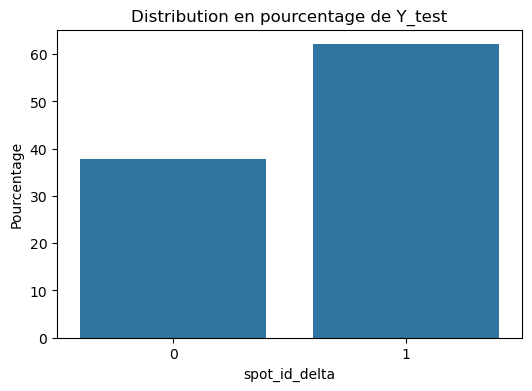

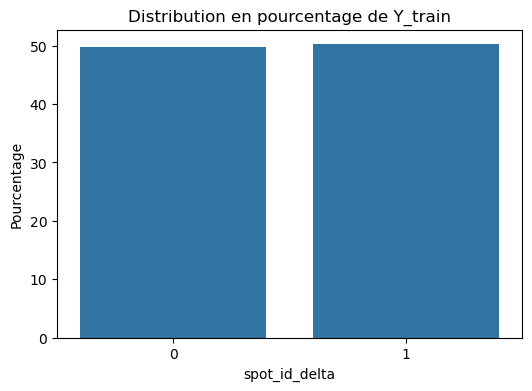

In [33]:
# Affichage des proportions en pourcentage pour Y_train et Y_test
print("Distribution en pourcentage de Y_train:")
print(Y_train['spot_id_delta'].value_counts(normalize=True) * 100)

print("\nDistribution en pourcentage de Y_test:")
print(Y_test['spot_id_delta'].value_counts(normalize=True) * 100)

# Graphique pour Y_test avec proportions
plt.figure(figsize=(6, 4))
prop_test = Y_test['spot_id_delta'].value_counts(normalize=True) * 100
sns.barplot(x=prop_test.index, y=prop_test.values)
plt.title('Distribution en pourcentage de Y_test')
plt.xlabel('spot_id_delta')
plt.ylabel('Pourcentage')
plt.show()

# Graphique pour Y_train avec proportions
plt.figure(figsize=(6, 4))
prop_train = Y_train['spot_id_delta'].value_counts(normalize=True) * 100
sns.barplot(x=prop_train.index, y=prop_train.values)
plt.title('Distribution en pourcentage de Y_train')
plt.xlabel('spot_id_delta')
plt.ylabel('Pourcentage')
plt.show()


La proportion de 0 dans `spot_id_delta` (indiquant que le prix Intraday est inférieur au prix SPOT) est significativement plus faible dans `Y_test` que dans `Y_train`. La dynamique du marché a considérablement changé, ce qui rend difficile pour les modèles entraînés sur des données antérieures de prédire avec précision le comportement du marché pendant la période de test. Alors que sur le trainign test la proportion est équilibré, on compte bien moins de cas où le prix intra jorunalier est infèrieur au prix spot dans el set `Y_test`.


c:\Users\tmont\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


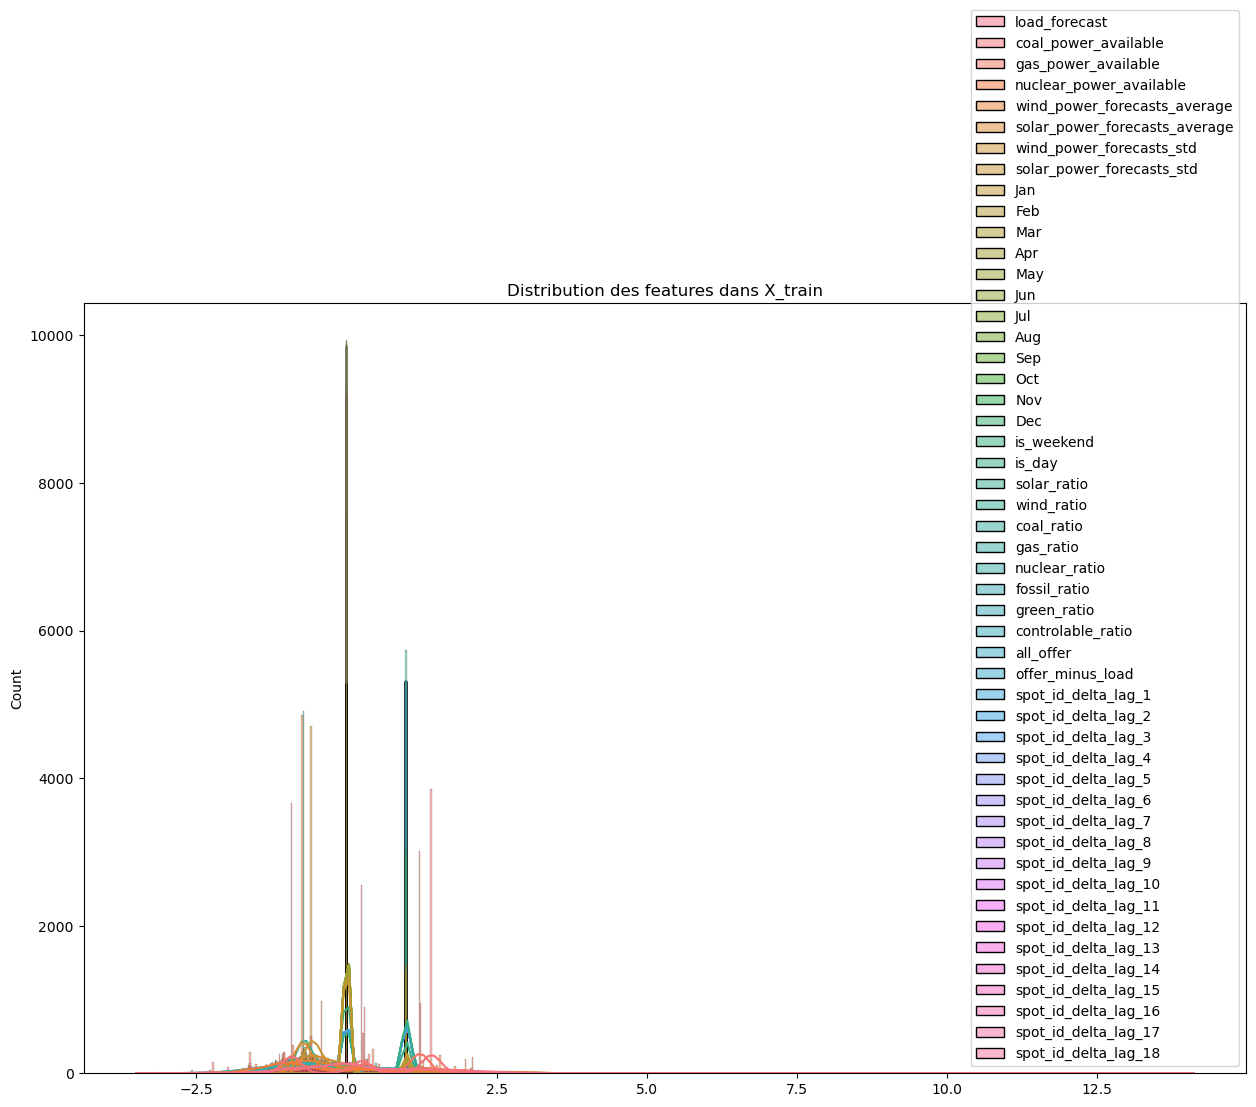

c:\Users\tmont\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


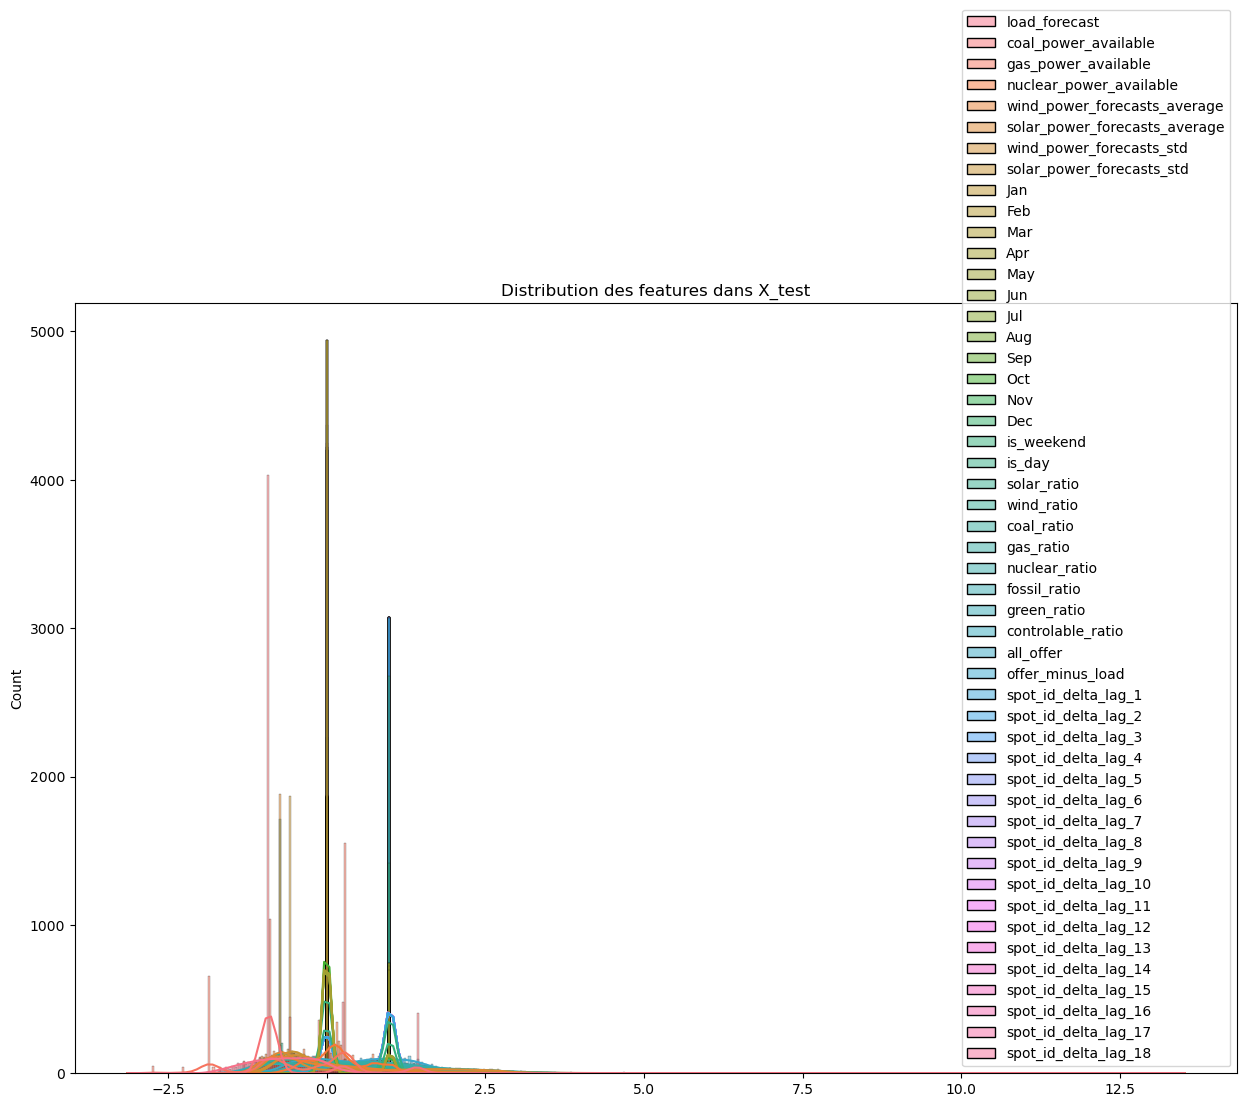

In [34]:
# Afficher la distribution des features dans X_train
plt.figure(figsize=(15, 10))
sns.histplot(data=X_train, kde=True)
plt.title('Distribution des features dans X_train')
plt.show()

# Afficher la distribution des features dans X_test
plt.figure(figsize=(15, 10))
sns.histplot(data=X_test, kde=True)
plt.title('Distribution des features dans X_test')
plt.show()

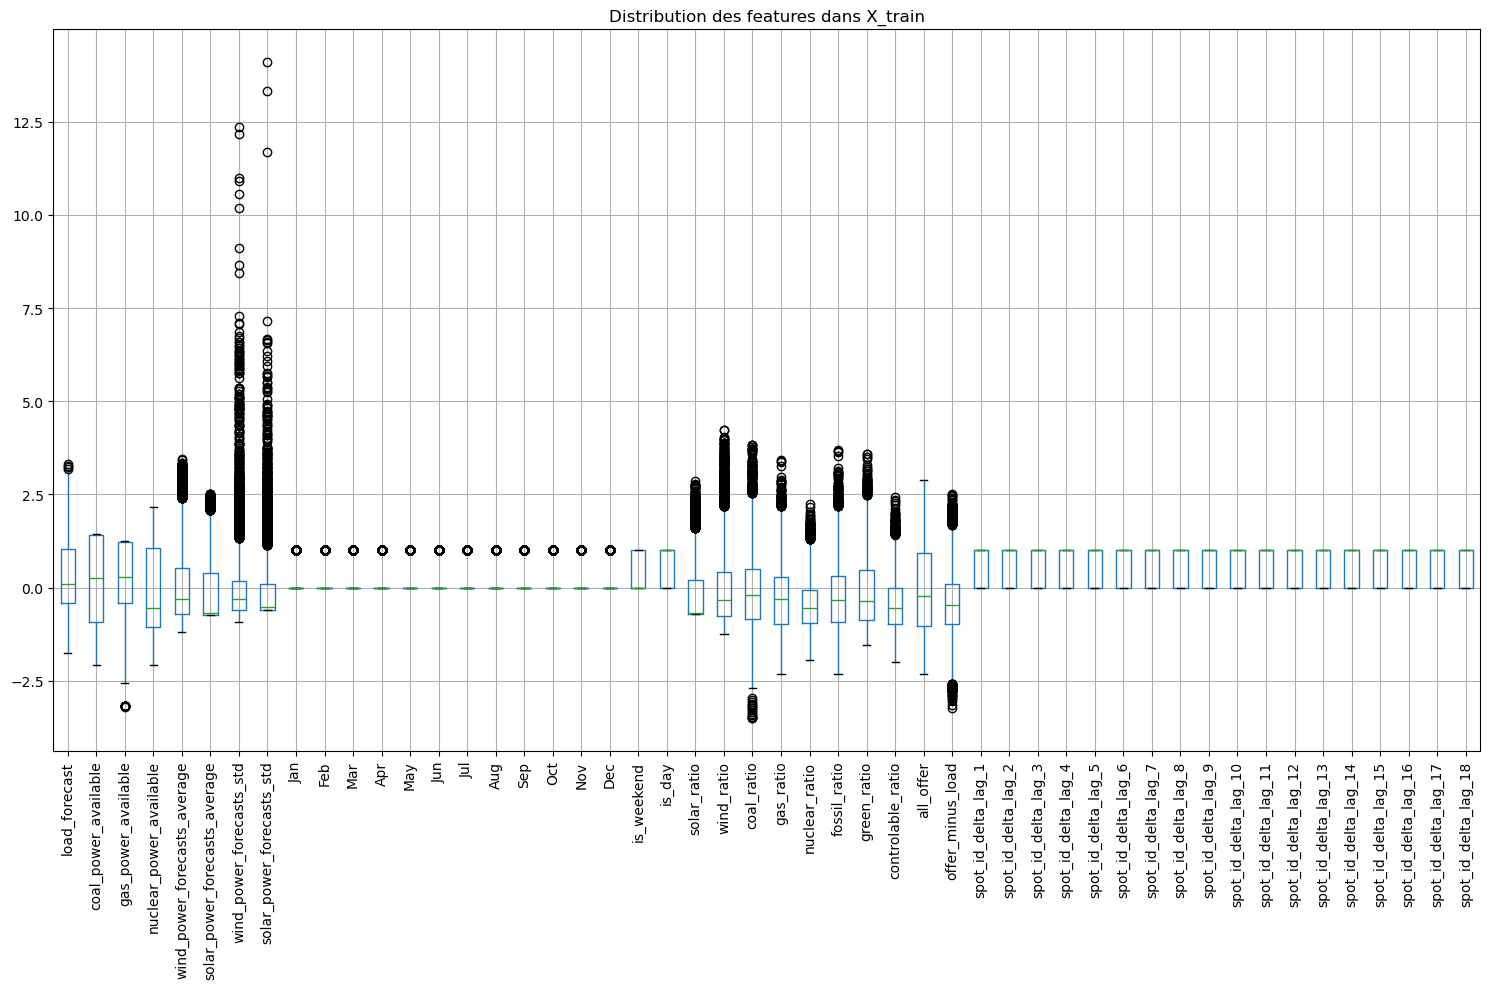

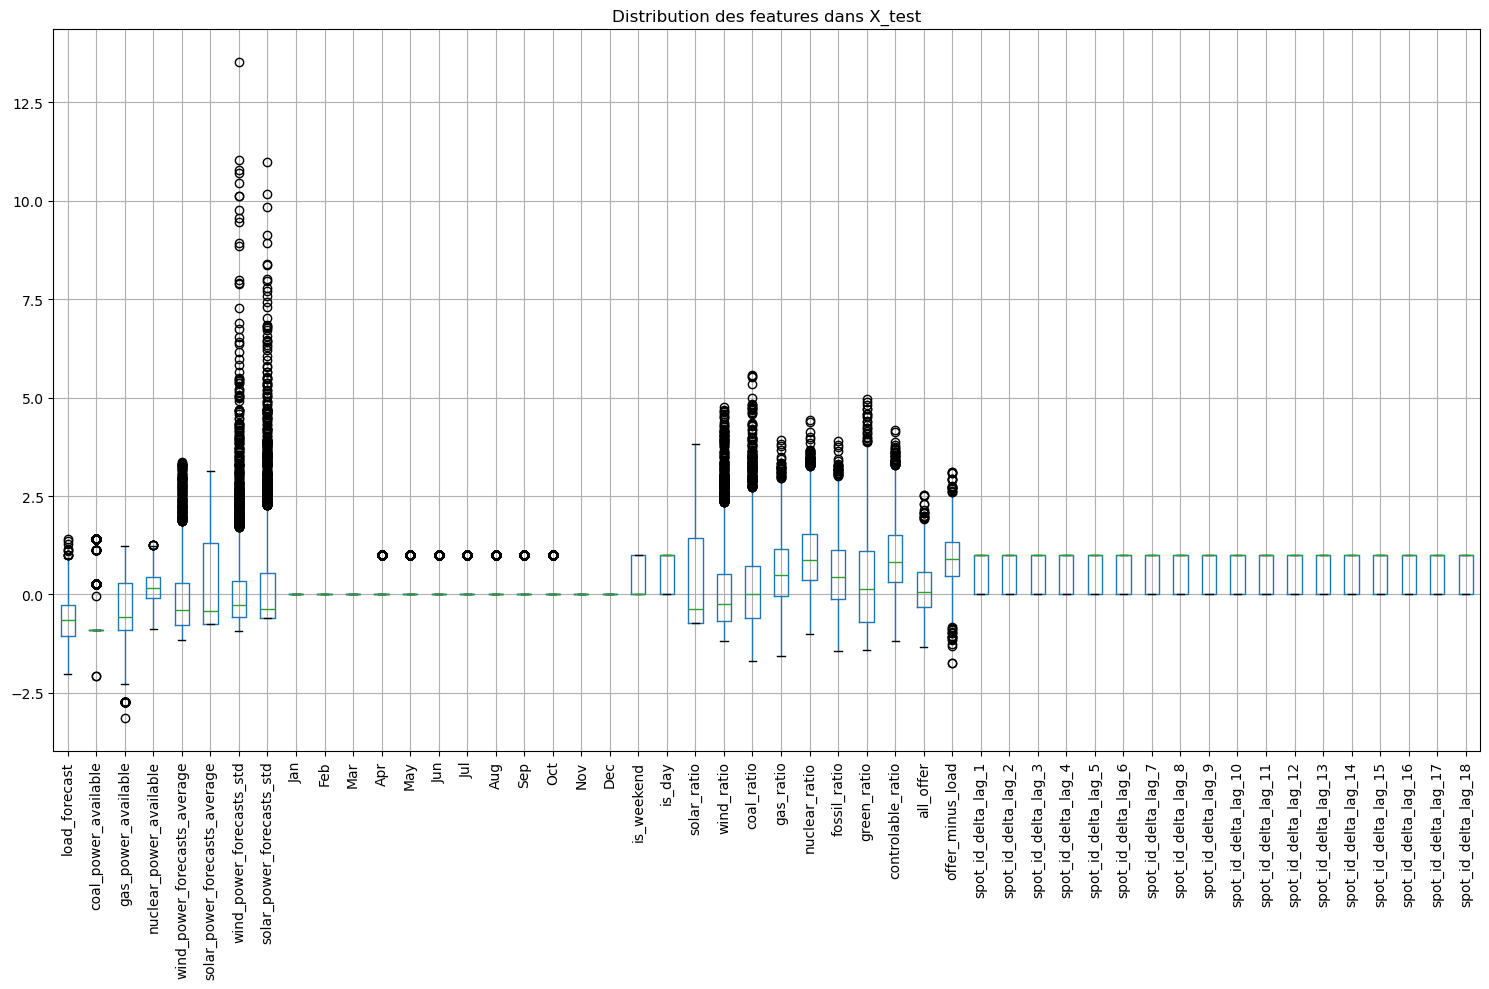

In [35]:
# Créer une boîte à moustaches pour chaque feature dans X_train
plt.figure(figsize=(15, 10))
X_train.boxplot()
plt.title('Distribution des features dans X_train')
plt.xticks(rotation=90)  # Pour une meilleure lisibilité des noms de features
plt.tight_layout()  # Ajuste les paramètres de sous-graphiques pour un espacement correct
plt.show()

# Créer une boîte à moustaches pour chaque feature dans X_test
plt.figure(figsize=(15, 10))
X_test.boxplot()
plt.title('Distribution des features dans X_test')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Le set de test ne comprend pas les mois d'hiver, contrairement au set d'entraînement, ce qui conduit à des différences dans la distribution temporelle des données.
- Les features associées aux mois de janvier et février sont très présentes dans les données d'entraînement, alors qu'elles sont quasi absentes dans le test.

Ces variations temporelles entraînent une modification de la distribution des features, notamment :
- Des variations naturelles dans les variables liées à la charge électrique, comme "load_forecast".
- Des différences dans les ratios énergétiques (par exemple, solar_ratio, wind_ratio, etc.).
- Une distribution qui change pour les variables sensibles à la saisonnalité.

Ainsi, le modèle devra s'adapter à des conditions saisonnières qui n'ont pas été observées durant l'entraînement, ce qui peut impacter ses performances et nécessite une attention particulière lors de l'évaluation des résultats.


In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

Y_train_series = Y_train['spot_id_delta'] if isinstance(Y_train, pd.DataFrame) else Y_train
Y_test_series  = Y_test['spot_id_delta'] if isinstance(Y_test, pd.DataFrame) else Y_test

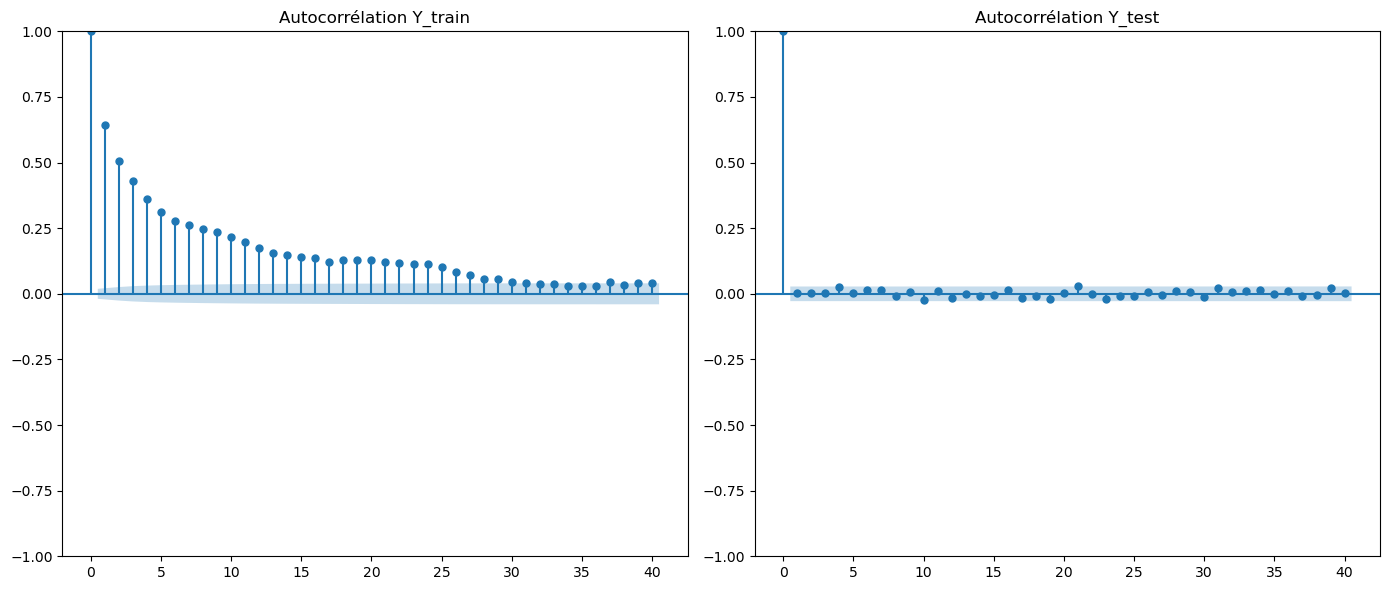

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_acf(Y_train_series, lags=40, ax=axes[0])
axes[0].set_title("Autocorrélation Y_train")

plot_acf(Y_test_series, lags=40, ax=axes[1])
axes[1].set_title("Autocorrélation Y_test")

plt.tight_layout()
plt.show()

L'analyse des graphiques d'autocorrélation met en lumière un défi majeur dans l'élaboration de notre modèle de prédiction des prix de l'énergie. En effet, nous constatons un contraste saisissant entre les schémas d'autocorrélation des ensembles d'entraînement et de test, révélant ainsi des pièges potentiels dans l'ingénierie des caractéristiques.

Pour l'ensemble d'entraînement (y_train), on observe une autocorrélation positive marquée qui décroît progressivement avec le temps. Ce comportement suggère l'existence de dépendances temporelles dans les fluctuations des prix spot. Fort de cette observation, nous avions intégré des caractéristiques retardées de delta spot (jusqu'à -18 sur les valeurs brutes), qui semblaient statistiquement significatives dans ces données.

Cependant, l'analyse de l'ensemble de test (y_test) présente une tout autre réalité : aucun schéma d'autocorrélation significatif n'apparaît au-delà du décalage 0. Cela explique pourquoi les modèles performants sur l'ensemble d'entraînement peinent à prédire les données de test.

Il est néanmoins intéressant de noter que, malgré cette inadéquation apparente, les modèles intégrant des caractéristiques rétrospectives surpassent ceux qui n'en disposent pas. Cela indique que, même si la structure d'autocorrélation ne se transfère pas parfaitement entre les ensembles, les variables retardées apportent des informations précieuses qui améliorent la précision des prédictions.


### Besoin de d'avantage de données

- Au niveau de la création de features et de l'imputation, nous avons obtenu de bons résultats, validés par le professeur.
- Cependant, il semble que nous manquions de données en quantité pour assurer une meilleure généralisabilité du modèle, ou bien de nouvelles features qui n'étaient pas accessibles dans le cadre du challenge.
- Par exemple, intégrer une variable température, et notamment détecter des anomalies par rapport aux normes saisonnières (comme une tempête de neige pouvant impacter le marché du SPOT), aurait apporté une dimension supplémentaire.
- De plus, des données complémentaires sur le prix du charbon ou du gaz auraient été très utiles pour enrichir l'analyse et améliorer les performances prédictives.
